## Machine Learning - Lab 05 - K-means Clustering

* Full name: Đinh Anh Huy
* Student ID: 18110103

In [1]:
import numpy as np 
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

In [2]:
class K_Means:
  def __init__(self, n_clusters=3, random_state=0):
    self.n_clusters = n_clusters
    self.rnd = np.random.RandomState(random_state)
    self.list_centroids = []
    self.list_labels = []
    self.inertia_ = None
    self.cluster_centers_ = None
    self.labels_ = None
    self.n_iter_ = None

  def _calc_wcv(self, X, centroids):
    differences = cdist(X, centroids)
    return np.sum(np.min(differences, axis=1)**2)

  def _calc_distribution(self, X, centroids):
    differences = cdist(X, centroids)
    wcv = self._calc_wcv(X, centroids)
    return np.min(differences**2, axis=1)/wcv

  def _get_centroid(self, X, distribution):
    return X[self.rnd.choice(range(len(distribution)), 1, p=distribution), :]
  
  def _init_centroids(self, X):
    centroids = X[self.rnd.choice(X.shape[0],1),:]
    while centroids.shape[0] < self.n_clusters :  
      p = self._calc_distribution(X, centroids)
      centroids = np.r_[centroids, self._get_centroid(X, p)]
    self.list_centroids.append(centroids)

  def _assign_label(self, X, centroids):
    differences = cdist(X, centroids)
    return np.argmin(differences, axis=1)

  def _has_converged(self, old_centroids, new_centroids):
    return (set([tuple(c) for c in old_centroids]) == set([tuple(c_new) for c_new in new_centroids]))

  def _update_centroids(self, X, labels):
    centroids = np.zeros((self.n_clusters, X.shape[1]))
    for k in range(self.n_clusters):
      Xk = X[labels == k, :]
      centroids[k,:] = np.mean(Xk, axis = 0)
    return centroids    

  def fit(self, X):
    if type(X) is not np.ndarray:
      X = X.toarray()

    self._init_centroids(X)
    iter = 0
    while True:
      self.list_labels.append(self._assign_label(X, self.list_centroids[-1]))
      new_centroids = self._update_centroids(X, self.list_labels[-1])
      if self._has_converged(self.list_centroids[-1], new_centroids):
        break
      self.list_centroids.append(new_centroids)
      iter += 1
    self.inertia_ = self._calc_wcv(X, self.list_centroids[-1])
    self.n_iter_ = iter
    self.labels_ = self.list_labels[-1]
  
  def predict(self, X):
    return self._assign_label(X, self.list_centroids[-1])

### Bài tập 1. Hãy dùng thuật toán K-mean để chọn ra số cụm thích hợp dựa trên tập training, và dự đoán label của các quan sát trên tập testing của bộ dữ liệu bên dưới.

In [3]:
data = pd.read_csv('https://raw.githubusercontent.com/huynhthanh98/ML/master/lab-05/data.csv')
data.head()

,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
data.isnull().sum()

CustomerID                0
Genre                     0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [5]:
print('>> Shape of data before dropping duplicate: ', data.shape)
data.drop_duplicates(inplace=True)
print('>> Shape of data after dropping duplicate: ', data.shape)

>> Shape of data before dropping duplicate:  (200, 5)
>> Shape of data after dropping duplicate:  (200, 5)


In [6]:
X = data.iloc[:, [2, 3]].values

X_train, X_test = train_test_split(X, test_size=0.33, random_state=42)
print('>> Shape of training set: ', X_train.shape)
print('>> Shape of testing set: ', X_test.shape)

>> Shape of training set:  (134, 2)
>> Shape of testing set:  (66, 2)


In [7]:
def elbow_plot(X, max_n_cluster, random_state):
  fig, ax = plt.subplots(figsize = (10,5))
  WSSs = []
  for i in range(1, max_n_cluster+1):
      model = K_Means(n_clusters=i, random_state=random_state)
      model.fit(X)
      wcv = model.inertia_
      WSSs.append(wcv)
  ax.plot(range(1, max_n_cluster+1), WSSs, marker='o')
  ax.set_xlabel('Number of clusters')
  ax.set_ylabel('Total Within Sum of Square')
  plt.show()

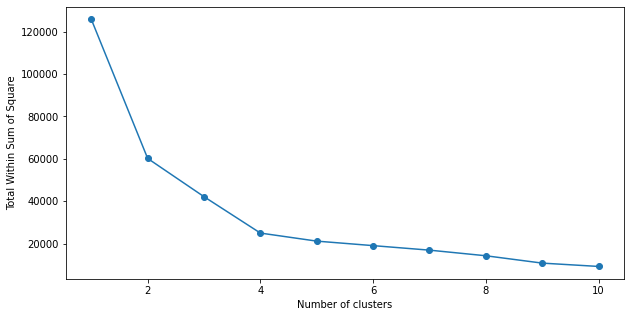

In [8]:
elbow_plot(X_train, 10, 42)

Từ đồ thị trên, ta chọn $K = 4$ là số cụm thích hợp.

In [9]:
model = K_Means(n_clusters=4, random_state=42)
model.fit(X_train)
print('>> Total Within Sum of Square: ', model.inertia_)
label_pred = model.predict(X_test)
print('>> Predicted labels: \n', label_pred)

>> Total Within Sum of Square:  24957.086886944147
>> Predicted labels: 
 [2 1 3 2 3 2 1 2 0 1 3 0 2 2 0 2 3 2 3 1 2 1 2 2 1 3 2 3 2 2 1 1 3 2 2 3 2
 2 2 3 3 0 1 3 2 0 1 1 2 3 2 2 1 2 3 3 2 3 2 3 2 2 1 3 1 3]


### Bài tập 2. Vẽ hình các cụm trên tập testing

In [10]:
def display_clustering(X, labels, colors, ncol_legend=2, figsize=(10,5)):
  fig, ax = plt.subplots(figsize=figsize)
  label = np.unique(labels)
  for i, c in zip(label, colors):
      ax.scatter(X[labels == i][:, 0], X[labels == i][:, 1], marker='o', color=c, label = 'cluster_' + str(i))
  plt.legend(ncol=ncol_legend)
  plt.show()

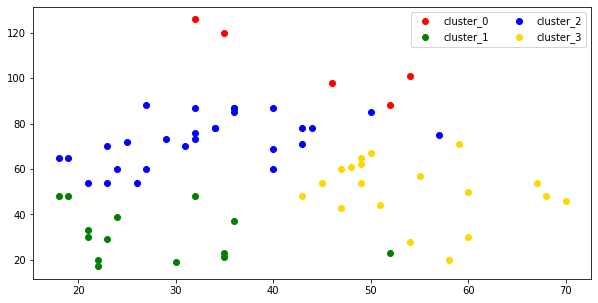

In [11]:
colors = ['red', 'green', 'blue', 'gold']
display_clustering(X_test, label_pred, colors=colors)

### Kết quả chạy bằng thư viện scikit-learn

In [12]:
model_skl = KMeans(n_clusters=4, random_state=42)
model_skl.fit(X_train)
print('>> Total Within Sum of Square: ', model_skl.inertia_)

label_pred_skl = model_skl.predict(X_test)
print('>> Predicted labels: \n', label_pred_skl)

>> Total Within Sum of Square:  24957.08688694415
>> Predicted labels: 
 [1 2 0 1 0 1 2 1 3 2 0 3 1 1 3 1 0 1 0 2 1 2 1 1 2 0 1 0 1 1 2 2 0 1 1 0 1
 1 1 0 0 3 2 0 1 3 2 2 1 0 1 1 2 1 0 0 1 0 1 0 1 1 2 0 2 0]


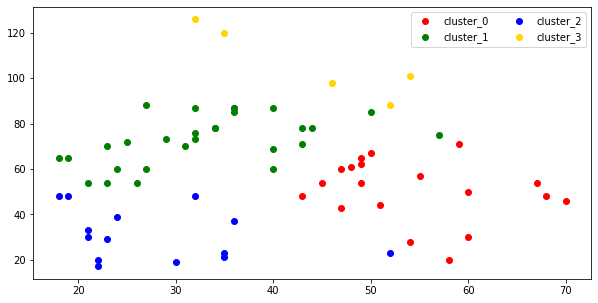

In [13]:
display_clustering(X_test, label_pred_skl, colors=colors)